## Skorch backprop network

In [6]:
import numpy as np
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
from pyperch.neural.backprop_nn import BackpropModule 
import matplotlib.pyplot as plt

In [7]:
from src.alien import alien

obj=alien()
X_train, y_train=obj.dataset(modify_feature=True)
X = X_train.astype(np.float32)
y = y_train.astype(np.int64)

In [8]:
from skorch.callbacks import EpochScoring 

net = NeuralNetClassifier(
    module=BackpropModule,
    module__input_dim=7,
    module__output_dim=2,
    module__hidden_units=10,
    module__hidden_layers=1,
    max_epochs=1000,
    verbose=0,
    callbacks=[EpochScoring(scoring='accuracy', name='train_acc', on_train=True),],
    criterion=nn.CrossEntropyLoss,
    optimizer=optim.SGD,
    lr=.05,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
)

In [9]:
import time
start=time.time()
net.fit(X, y)
print(time.time()-start)
print(net.history[:, 'valid_acc'][-1])


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BackpropModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=7, out_features=10, bias=True)
      (1): Linear(in_features=10, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
  ),
)

## Plot learning curves

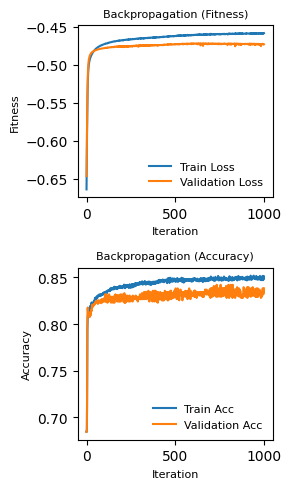

In [14]:
# plot the iterative learning curve (loss)
fig = plt.figure(figsize=(3,5))
ax1=fig.add_subplot(2,1,1)



plt.plot(-np.array(net.history[:, 'train_loss']), label='Train Loss')
plt.plot(-np.array(net.history[:, 'valid_loss']), label='Validation Loss')
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Fitness")
ax1.set_title("Backpropagation (Fitness)")
# plt.grid(visible=True)
plt.legend(frameon=False)

ax2=fig.add_subplot(2,1,2)
plt.plot(net.history[:, 'train_acc'], label='Train Acc')
plt.plot(net.history[:, 'valid_acc'], label='Validation Acc')
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")
ax2.set_title("Backpropagation (Accuracy)")
# plt.grid(visible=True)
plt.legend(frameon=False)


plt.rcParams.update({
    'font.size': 10,          # General font size
    'axes.titlesize': 8,     # Font size for titles
    'axes.labelsize': 8,     # Font size for x and y labels
    # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
    # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
    'legend.fontsize': 8     # Font size for legend
})

plt.tight_layout() 
plt.savefig('figs/fitness_NN.pdf')
plt.show()

## Using sklearn learning curve with RO

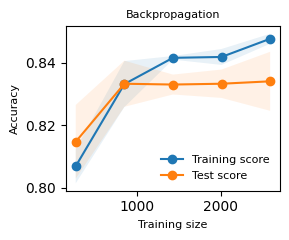

In [11]:
from sklearn.model_selection import learning_curve


train_sizes, train_scores, test_scores = learning_curve(
    net, X, y, train_sizes=np.linspace(0.1, 1.0, 5), cv=3
)


fig = plt.figure(figsize=(3,2.5))

train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     )
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,)
plt.plot(train_sizes, train_scores_mean, label="Training score", marker='o')
plt.plot(train_sizes, test_scores_mean, label="Test score",marker='o')
plt.title("Backpropagation")
plt.xlabel("Training size")
plt.ylabel("Accuracy")
# plt.grid(visible=True)
plt.legend(frameon=False)


plt.rcParams.update({
    'font.size': 10,          # General font size
    'axes.titlesize': 8,     # Font size for titles
    'axes.labelsize': 8,     # Font size for x and y labels
    # 'xtick.labelsize': 8,    # Font size for x-axis tick labels
    # 'ytick.labelsize': 8,    # Font size for y-axis tick labels
    'legend.fontsize': 8     # Font size for legend
})

plt.tight_layout() 
plt.savefig('figs/accuracy_NN.pdf')
plt.show()

## Using sklearn pipeline

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('net', net),
])

pipe.fit(X, y)
y_proba = pipe.predict_proba(X)

## Using sklearn grid search 

In [13]:
from sklearn.model_selection import GridSearchCV

# deactivate skorch-internal train-valid split and verbose logging
net.set_params(train_split=False, verbose=0)

default_params = {
    'module__input_dim': [12],
    'module__output_dim': [2],
}

# module specific parameters need to begin with 'module__'
params = {
    'lr': [0.01, 0.02],
    'max_epochs': [10, 20],
    'module__hidden_units': [10, 20],
    **default_params,
}
gs = GridSearchCV(net, params, refit=False, cv=3, scoring='accuracy', verbose=2)

gs.fit(X, y)
print("best score: {:.3f}, best params: {}".format(gs.best_score_, gs.best_params_))

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END lr=0.01, max_epochs=10, module__hidden_units=10, module__input_dim=12, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=10, module__input_dim=12, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=10, module__input_dim=12, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=20, module__input_dim=12, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=20, module__input_dim=12, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=10, module__hidden_units=20, module__input_dim=12, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=20, module__hidden_units=10, module__input_dim=12, module__output_dim=2; total time=   0.0s
[CV] END lr=0.01, max_epochs=20, module__hidden_units=10, module__input_dim=12, module__outpu

ValueError: 
All the 24 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/optim/sgd.py", line 66, in step
    loss = closure()
           ^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 993, in train_step_single
    y_pred = self.infer(Xi, **fit_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1521, in infer
    return self.module_(x, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/duan/Blue/mle/CS7641/A2/pyperch/neural/backprop_nn.py", line 76, in forward
    X = self.activation(self.layers[0](X))
                        ^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/linear.py", line 116, in forward
    return F.linear(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x7 and 12x10)

--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/classifier.py", line 165, in fit
    return super(NeuralNetClassifier, self).fit(X, y, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1319, in fit
    self.partial_fit(X, y, **fit_params)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1278, in partial_fit
    self.fit_loop(X, y, **fit_params)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1190, in fit_loop
    self.run_single_epoch(iterator_train, training=True, prefix="train",
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1226, in run_single_epoch
    step = step_fn(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1105, in train_step
    self._step_optimizer(step_fn)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1060, in _step_optimizer
    optimizer.step(step_fn)
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/optim/optimizer.py", line 385, in wrapper
    out = func(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/optim/optimizer.py", line 76, in _use_grad
    ret = func(self, *args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/optim/sgd.py", line 66, in step
    loss = closure()
           ^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1094, in step_fn
    step = self.train_step_single(batch, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 993, in train_step_single
    y_pred = self.infer(Xi, **fit_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/skorch/net.py", line 1521, in infer
    return self.module_(x, **fit_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/media/duan/Blue/mle/CS7641/A2/pyperch/neural/backprop_nn.py", line 76, in forward
    X = self.activation(self.layers[0](X))
                        ^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1511, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1520, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/duan/.conda/envs/ml/lib/python3.11/site-packages/torch/nn/modules/linear.py", line 116, in forward
    return F.linear(input, self.weight, self.bias)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x7 and 12x20)
